## Aggregate Metrics into Figures of Merit ##

**Credit:** Fabio Ragosta (INAF and University of Naples "Federico II") and Xiaolong Li (University of Delaware)

Very minor edits and explanatory comments ('###') by Will Clarkson, UM-Dearborn

**The notebook presents a function which take as input the bundleDicts from the metric and it builds a bar plot with the rank of all the opsims. The rank is estimated summing the metric value all over the footprint.**

### Some control variables ###

In [2]:
# Your username (for locating the MAF output to be plotted)
your_username = 'wiclarks'

# directory in your persistent workspace with MAF output
searchTail = 'MAFOutput/MetricData/PM' 

# Path for output table
pathTableOut = './testFoMs.csv'

# Ranking the FoMs by family?
byFamily = True

# colormap for plot
cmap='viridis_r'

In [3]:
%matplotlib inline
import sys,os, glob
import numpy as np
import math
from lsst.sims.maf.utils.opsimUtils import *

# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')
from opsimUtils import *

import matplotlib.pyplot as plt
import pandas as pd
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils import m52snr, sigma_slope, astrom_precision
from builtins import zip

In [4]:
# to aggregate the results into a table for convenient output
from astropy.table import Table, Column

In [5]:
## plt.style.use('seaborn') # moved to lower down in the notebook to take effect
plt.rc('legend', fontsize=10)

- your_username has to be set to be able to access to the proper directory.

- outDir has to be set to be able to access to the MAFOutput file.

In [6]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')
    
### 2020-08-06 updated to search for "result" and "data" paths separately
# outDir = '/home/idies/workspace/Storage/{}/persistent/{}'.format(your_username, searchTail)

resultDbPath = '/home/idies/workspace/Storage/{}/persistent/{}'.format(your_username, searchTail)
metricDataPath =  '/home/idies/workspace/Storage/{}/persistent/{}'.format(your_username, searchTail)

resultDbs = getResultsDbs(resultDbPath)

# the following line will be useful if you did not run MAF on all 75 opsims
#Here we upload the results from the MAFoutput of interest
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in runNames:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slic

nomalization factors and/or tresholds for the FOM and MAF values can be set in the function to plot the selection we want to show.

- norm can be a string ('std'),in this case it apply as normalization the standard deviation of the MAF distribution over the footprint; norm can be None, in this case no normalization is applyed; norm can be a dictionary with the normalization value for all the opsim for the number of metrics we want to plot.

- threshold_max is the upper limit for the threshold.

- treshold_max is the lower limit for the threshold.

- byfamily is a boolean variable, if True the Opsims are sorted by theri families.

In [7]:
def get_family(df):
    """get family of opsim"""
    
    ### Uses string parsing of the OpSIM filename to determine the family to which the opsim belongs.
    return df[0].split('_')[0]

def FOM(bundleDicts, norm=None, treshold_min =None, treshold_max =None, filename=None, byfamily=True, \
        tablePath='', Verbose=True, cmap='plasma', **karg):
    data_bundle = {}
    data = {}
    FOMs = [] ### One figure of merit per metric per run. Shape: (nMetrics x nRuns)
    runNames= list(bundleDicts.keys())
    metrics = bundleDicts[runNames[0]].keys()
          
    
    for metric in metrics:
        data_bundle[metric]={}
        data[metric]={}
        FOM=[]
        for runName in runNames: 
            
            ### Re-form the MAF output into a Pandas dataframe for easier processing below
            data_bundle[metric][runName]= pd.DataFrame(bundleDicts[runName][metric].metricValues[np.where(bundleDicts[runName][metric].metricValues.mask == False)])[0]
            data[metric][runName]= [] 

            ### Accumulate a 1D array of metric values for this metric for this run, over the set of HEALPIX
            ### for which a valid and finite metric value is found. 
            for i in range(len(data_bundle[metric][runName])):        
                if data_bundle[metric][runName][i]:
                    data[metric][runName].append(data_bundle[metric][runName][i])
            data[metric][runName]=np.array(data[metric][runName])[np.where(np.isfinite(data[metric][runName]))]

            ### If the user specified lower and upper thresholds, only consider further those HEALPIX whose
            ### value for *this* metric lies between the thresholds. The thresholds can be supplied either as 
            ### a dictionary with one value per metric, or as a single scalar each for hi and lo over all
            ### the metrics. If no threshold was given, consider all the HEALPIX for which this metric has 
            ### been computed. 
            if treshold_min !=None and treshold_max !=None :
                if isinstance(treshold_min,dict) and isinstance(treshold_max,dict):
                    ID_fom=np.where((data[metric][runName]>treshold_min[metric][runName]) & (data[metric][runName]<treshold_max[metric][runName]))
                else:
                    ID_fom=np.where((data[metric][runName]>treshold_min) & (data[metric][runName]<treshold_max))
            else:
                if treshold_min !=None:
                    if isinstance(treshold_min,dict):
                        ID_fom=np.where(data[metric][runName]>treshold_min[metric][runName])
                    else:
                        ID_fom=np.where(data[metric][runName]>treshold_min)
                elif treshold_max !=None :
                    if isinstance(treshold_min,dict):
                        ID_fom=np.where(data[metric][runName]>treshold_max[metric][runName])
                    else:
                        ID_fom=np.where(data[metric][runName]>treshold_max)
                else:
                    ID_fom=np.repeat(True, len(data[metric][runName]))
            
            ### Normalize this metric value over its run of values across the set of HEALPIX. Choice of 
            ### normalization user-selectable: if a dictionary is passed in as "norm" - one value per metric
            ### - then that normalization is used. Default is to do no rescaling. 
            if norm =='std':
                N= 1.0/np.std(data[metric][runName][ID_fom])
            elif norm==None:
                N=np.repeat(1,len(data[metric][runName][ID_fom]))
            else:
                N=norm[metric][runName][ID_fom]
            
            ### Metric value for each HEALPIX, normalized by factor N (see options above)
            fom = np.array(data[metric][runName][ID_fom])*N
            
            ### Sum this metric for this run over the HEALPIX, and append to master-array over the runs
            FOM.append(fom.sum())
           
        ### Append the run of FoMs for this metric over the runs, to the master-list of FoMs for all the 
        ### metrics. This list consists of one 1D (length nRuns) numpy array per metric.
        FOM=np.array(FOM)
        FOMs.append(FOM) 
    
    # 2020-08-05 package the FOMs into a table so that we can output to disk
    ### Only write the table if the user has specified an output filename for it to be written to.
    ### (Do we want the method to return the table back to the calling cell?)
    if len(tablePath) > 3:
        tWrite = Table()
        tWrite['runNames'] = runNames
        for iMetric in range(len(metrics)):
            thisFom = FOMs[iMetric]
            
            ### 2020-08-06 hack to handle repeated metric names
            indexStr = ('%i' % (iMetric)).zfill(2)
            metricName = list(metrics)[iMetric][-1]
            colName = '%s_%s' % (indexStr, metricName)
            thisCol = Column(name=colName, data=thisFom)
            tWrite.add_column(thisCol)
            
        ### Add a column giving the sum over the metrics for each run and write to disk
        tWrite.add_column(Column(name='FomSum', data=np.sum(FOMs, axis=0)))           
        tWrite.write(tablePath, overwrite=True)
        
        ### If the user wants to see screen output, create a copy of a subset of the table, 
        ### format the numbers sensibly, and print the subset to stdout.
        if Verbose:
            print("Written FoM sums to path %s. Contents:" % (tablePath))
            tShow = Table(data=tWrite[0:3], copy=True)
            for colSho in tShow.colnames:
                if colSho == 'runNames':
                    continue
                tShow[colSho].format='%.3f'
            tShow.pprint()
            
    # --- end of syntax to construct and write table --- 
            
    import matplotlib.cm as cm
    
    ### Apply matplotlib settings and a stylesheet
    plt.rcdefaults()
    plt.style.use('seaborn-dark')
     
    fig, ax = plt.subplots(figsize=(8,30))
    y_pos = np.arange(len(bundleDicts.keys()))
    
    ### make colormap user-selectable:
    try:
        ccm = cm.get_cmap(cmap)
    except:
        ccm = cm.get_cmap('rainbow')
    colorlist = ccm(np.linspace(0, 1, len(FOMs)))
    d= np.zeros(len(runNames))
    dplt=[]
    
    ### Inherit the plot labels from the set of MAF outputs
    FOM_labels= list(bundleDicts[runNames[0]].keys())
    df_new = pd.DataFrame(bundleDicts.keys(), columns=['db'])
    for i, (FOM, maf) in enumerate(zip(FOMs,FOM_labels)):
        d = d+ FOM
        #dplt.append(d)
        df_new[maf]= d
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.4_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.4_10yrs", "") )
    df_new['family'] = df_new.apply(get_family, axis=1)

    ### Optionally, rank the FoMs in the plot by family, as determined by string parsing
    ### of the OpSIM filename (see "def get_family()" above in this cell.). Otherwise, 
    ### rank globally over the entire set of runs.
    if byfamily:
        df_ = df_new.sort_values(by=[ 'family',FOM_labels[-1]], ascending=[False, False])
    else:
        df_ = df_new.sort_values(by=[FOM_labels[-1]], ascending=[False])
    
    ##df_ = df_new.sort_values(by=[ 'family',FOM_labels[-1]], ascending=[False, False])
    #idx = sorted([name_tick,d], key = lambda x: (x[1],x[2]))
    #idx=np.argsort((d,name_tick))
    #idx=idx[::-1]
    
    ### Adds the stacked bar plot for each run to the bar plot, in descending order of rank
    for i in reversed(range(len(FOMs))):
        #ax.barh(y_pos,dplt[i][idx], align='center',color=colorlist[i],label=FOM_labels[i], **karg)
        ax.barh(df_['db'],df_[FOM_labels[i]], align='center',color=colorlist[i],label=FOM_labels[i], \
                zorder=5, **karg)
    
    xmin, xmax= ax.get_xlim() ### To enforce sensible horizontal axis limits later
    
    ### If ranking within the families, draw divider lines to visually partition the families in the 
    ### output figure.
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()[FOM_labels[-1]].values - 0.5
        hlines = [hlines, hlines]   
        ax.plot((xmin, xmax), hlines, 'k-', linewidth=1, alpha=0.5)
    ax.set_yticks(y_pos)
    #ax.set_yticklabels(name_tick, size=20)
    ax.set_yticklabels(df_['db'])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('FoM', fontsize=20)
    leg = ax.legend(loc='upper right', fontsize=14, frameon=True)
    legFrame = leg.get_frame()
    legFrame.set_color('white')
    
    ### Add vertical gridlines to guide the eye
    ax.grid(which='both', axis='x', color='w', alpha=0.9, zorder=1, lw=1)
    
    if filename!=None:
        plt.savefig(filename+'.png')
    plt.close()
    return fig ### (WIC) - seems to be required for the plot to appear in the notebook.

Written FoM sums to path ./testFoMs.csv. Contents:
        runNames         00_LSPMmetric 01_TransienPM 02_confusionmetric  FomSum 
------------------------ ------------- ------------- ------------------ --------
      spiders_v1.4_10yrs       121.370       765.479            743.514 1630.364
       agnddf_v1.4_10yrs       147.211       777.393            500.710 1425.313
twi_filters_5_v1.4_10yrs       136.950       770.357            743.557 1650.864


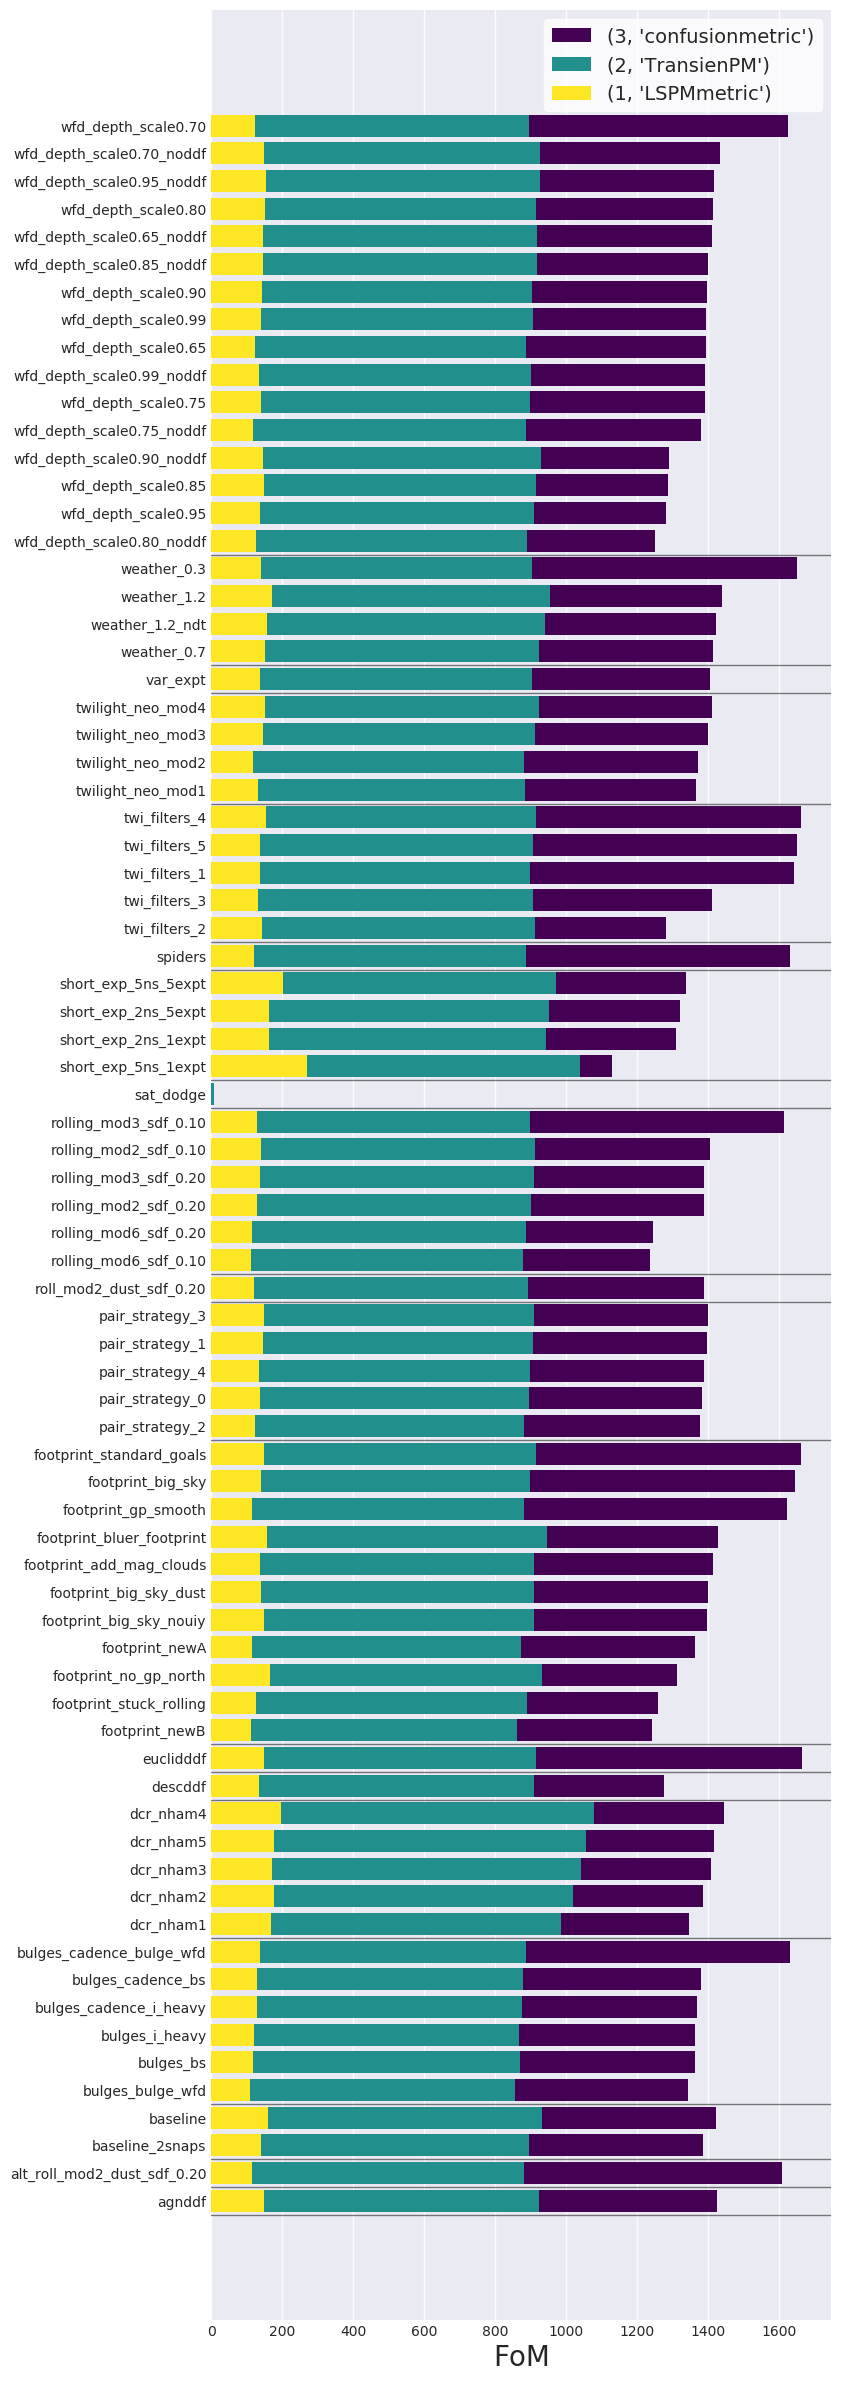

In [8]:
# example call including writing the table of the FoMs to disk and 
# showing the first few lines of the table to terminal. 
FOM(bundleDicts, tablePath=pathTableOut, Verbose=True, byfamily=byFamily, cmap=cmap)

/home/idies/workspace/Storage/wiclarks/persistent/forks/LSST_OpSim/contrib
